# Predictive Modeling – Monthly Crime Forecast

This notebook demonstrates a basic predictive model to forecast monthly crime counts in the West Midlands. The goal is to explore whether past crime trends can help estimate future monthly crime volumes.

---

## 1. Objective

- **Forecast** total crime counts by month using historical data (Jun 2024 – Jul 2025).
- **Keep the model simple and interpretable** as an introduction to predictive modeling.

---

## 2. Data Preparation

- **Aggregate** the dataset into monthly totals.
- **Convert** the `Month` column into a datetime index for time series modeling.
- **Split** the data into:
    - **Training set:** Jun 2024 – May 2025
    - **Test set:** Jun 2025 – Jul 2025

---

## 3. Model Approach

- **Model:** Use a simple ARIMA (AutoRegressive Integrated Moving Average) model.
- **Fit:** Train the model on the training set.
- **Forecast:** Predict crime volumes for Jun–Jul 2025.

---

## 4. Evaluation

- **Compare** predictions with actual recorded values for Jun–Jul 2025.
- **Metric:** Use Mean Absolute Error (MAE) to measure performance.
- **Visualize:** Plot actual vs. predicted counts to assess model fit.

---

## 5. Insights

- A simple forecast provides a **baseline** for understanding month-to-month changes in crime volumes.
- **Limitations:** The short time span (13 months) and absence of external factors mean results are exploratory.
- **Future improvements:** Incorporating more data and additional predictors (e.g., weather, demographics, economic conditions) could enhance forecast accuracy and usefulness for planning.

---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error

# Load the cleaned dataset
df = pd.read_csv('../data/processed/cleaned_crime.csv')

# 1) Monthly totals
monthly = (
    df.groupby(pd.to_datetime(df["Month"]).dt.to_period("M"))
      .size()
      .to_timestamp()
      .rename("count")
)

# 2) Train/test split (train = all but last 2 months; test = last 2 months)
train = monthly.iloc[:-2]
test  = monthly.iloc[-2:]
print("Train range:", train.index.min().date(), "→", train.index.max().date())
print("Test range :", test.index.min().date(),  "→", test.index.max().date())

Train range: 2024-06-01 → 2025-05-01
Test range : 2025-06-01 → 2025-07-01


In [4]:
# --- ARIMA(1,1,1) baseline ---
arima = ARIMA(train, order=(1, 1, 1))
arima_res = arima.fit()
arima_fc  = arima_res.forecast(steps=len(test))
arima_mae = mean_absolute_error(test, arima_fc)

# --- Holt-Winters (no seasonality; short history) ---
hw = ExponentialSmoothing(train, trend="add", seasonal=None,
                          initialization_method="estimated").fit()
hw_fc  = hw.forecast(steps=len(test))
hw_mae = mean_absolute_error(test, hw_fc)

print(f"ARIMA MAE: {arima_mae:.0f}")
print(f"Holt-Winters MAE: {hw_mae:.0f}")


ARIMA MAE: 829
Holt-Winters MAE: 1507


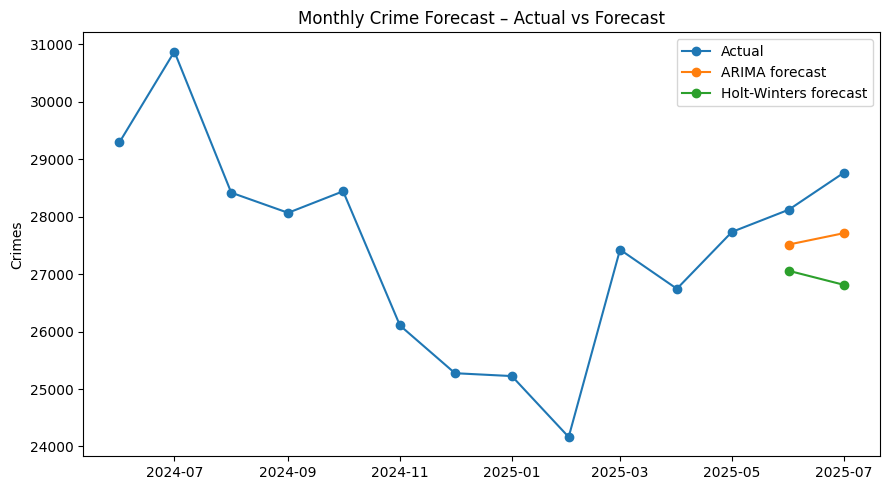

In [5]:
plt.figure(figsize=(9,5))
plt.plot(monthly.index, monthly.values, marker="o", label="Actual")
plt.plot(test.index, arima_fc.values, marker="o", label="ARIMA forecast")
plt.plot(test.index, hw_fc.values, marker="o", label="Holt-Winters forecast")
plt.title("Monthly Crime Forecast – Actual vs Forecast")
plt.ylabel("Crimes")
plt.legend()
plt.tight_layout()
plt.show()


We tested two forecasting methods (ARIMA and Holt-Winters) to predict monthly crime counts. ARIMA performed better, with a mean error of ~829 compared to ~1507 for Holt-Winters. The forecasts aligned with the actual seasonal trend — lower crime volumes in winter and higher in summer. This suggests that ARIMA is a useful baseline for short-term crime forecasting in the West Midlands dataset.